## PS
* run anything above work space  
* then modify L and K 

In [53]:
import networkx as nx
from numpy.linalg import matrix_power
import numpy as np
import matplotlib.pyplot as plt
import copy as cp
import math
from tqdm import tqdm

In [46]:
#plt.rcParams["figure.figsize"] = (18, 13)

In [47]:
def isklburnable(g, k, l):
    '''
    input:
    g: graph with networkx form
    k: number of sources
    l: number of rounds
    '''
    ############################################ Step0: get information
    N = nx.number_of_nodes(g)
    g_copy = cp.deepcopy(g)
    ''''''
    ########################################### Step1: get L
    L_list, tellburnfromL = getL(g, N, l, k)
    print(tellburnfromL)
    if tellburnfromL == True:
        return np.array(L_list[0]), [x for x in g.nodes()], True
    
    ########################################### Step2: initial
    source = -1*np.ones(k) #burnding sequence
    bestsequence = [[], []] #1st entry: burning sequence; 2nd: number of burned nodes by this bs
    
    R_dynamic = [cp.copy(L_list[0])]
    burned = []
    level_burned = [[]] 
    burned, source, level_burned, R_dynamic = updateR(k, L_list, g, 0, burned, source, level_burned, R_dynamic)
    
    #New check
    if len(burned) == N:
        return source, burned, True 

    ########################################### Step3: loop   
    while len(R_dynamic) != 0:
        while len(R_dynamic[k - 1]) != 0:
            '''1. check: finish burn k rounds'''
            # 1.1 pick source at end of round
            source[k - 1] = R_dynamic[k - 1][0] # pick 1st 
            R_dynamic[k-1].remove(R_dynamic[k - 1][0]) #remove 1st
            burned.append(source[k-1]) 
            burned = list(set(burned))
            
            if len(burned) == N:
                return source, burned, True
           
            '''2. burned B for rest rounds'''
            B = cp.copy(burned)# assign for iteration
            for rest_rounds in range(l - k): #l-k
                B = findB(B, g)
                B = list(set(burned))# remove replication
                if len(B) == N:
                    return source, B, True
                
            '''3. fail to burn '''
            burned.remove(source[k-1])
            if len(bestsequence[1]) < len(B):
                print('Best sequence', bestsequence[0], bestsequence[1])
                bestsequence[0] = cp.copy(source)
                bestsequence[1] = cp.copy(B)    
        
        
        #update variables to return 
        source[k-1] = -1
        del R_dynamic[-1]  
        level_burned[k - 2].remove(source[k - 2])
        del level_burned[k-1]
        upburned = []
        for i in level_burned:
            upburned = upburned + i
        
        burned, source, level_burned, R_dynamic = updateR(k, L_list, g, k-2, upburned, source, level_burned, R_dynamic) #go back to upper level 0, 1, ..., k-2, k-1 
        
        if len(burned) == N:
            return source, burned, True  
    
    return bestsequence[0], bestsequence[1], False

def getL(g, N, l, k):
    L_list = [[x for x in g.nodes()]]
    tellburnedfromL = False
    num_remove = 0
    
    gl = cp.deepcopy(g) #used for l
    initial = range(N) 
    for i in range(l - 1):
        leaves = updateL(initial, gl)
        initial = cp.deepcopy(leaves)
        L_list.append(initial)
    L_list.reverse()
    
    while(len(L_list[0]) == 0):
      del L_list[0]
      tellburnedfromL = True
      num_remove = num_remove + 1
    if len(L_list[0]) == 1:
      tellburnedfromL = True
    '''
    print("1得到L")
    print(L_list)
    print("\n")
    '''
    return L_list, tellburnedfromL

def updateL(input, g):#S1 get all leaves
    temp = [x for x in g.nodes() if g.degree(x)<=1] 
  #S2.1 remove leaves from graph
    for i in range(len(temp)): 
      g.remove_node(temp[i])
  #S2.2 return all non-leaves 
    return [x for x in input if x not in temp]

def findB(burned, gg):
    '''
        input: 
        a) burned: list of burned nodes
        b) gg: total graph
        output:
        nodes_burned_till_this_round
    '''
    nodes_burned_till_this_round = cp.copy(burned)
    # find all bunred vertice's neignbors
    for this_node in burned:
        nb_of_source = nx.all_neighbors(gg, this_node)
            
        for x in nb_of_source:
            if x not in nodes_burned_till_this_round: # keep unique
                nodes_burned_till_this_round.append(x)
    
    return nodes_burned_till_this_round #返回B set

def updateR(k, L_list, g, num, burned, source, level_burned, R_dynamic):
    # 0 judge and recursion
    '''0 precheck: walk upwards if the R set this level is empty'''
    if len(R_dynamic[num]) == 0: #this row does not exist
        if num == 0:
            del R_dynamic[-1]
            return burned, source, level_burned, R_dynamic
            
        del R_dynamic[num]
        del level_burned[num]
        level_burned[num - 1].remove(source[num - 1])
        
        #upburned will replace burned
        upburned = []
        for i in level_burned:
            upburned = upburned + i
        
        burned, source, level_burned, R_dynamic = updateR(k, L_list, g, num - 1, upburned, source, level_burned, R_dynamic)
        return burned, source, level_burned, R_dynamic


    '''1 normal process'''    
    # 1.the process of pick new source after burning
    
    max_degree = -1
    for i in R_dynamic[num]:
        if g.degree[i] > max_degree:
            source[num] = i
            max_degree = g.degree[i]
            
    R_dynamic[num].remove(source[num])
    burned.append(source[num])
    burned = list(set(burned)) # remove
    old_burned = cp.copy(burned)
    level_burned[num].append(source[num])

    # 2. update R
    # 2.1 get all burned nodes(B) in this round
    B = findB(burned, g)#TODO: copy? # PS: 也可以让findB只返回新burn的vertices
    # 2.2 update level_burn
    level_burned.append([node for node in B if node not in old_burned])#all burned this round - all burned last round
    burned = cp.copy(B) #update burn
    # 2.3 get L/B and update to the total R
    R_next_level = [node for node in L_list[num + 1] if node not in burned] #update R next level
    # deal with empty R
    if len(R_next_level) == 0:
        # case1: no lower options
        if num + 2 == len(L_list): 
            return burned, source, level_burned, R_dynamic
        
        # case2: walk down
        for inner_num in range(num + 2, len(L_list)): #choose [num + 2, ..., l - 1]
            R_next_level = [node for node in L_list[inner_num] if node not in burned]
            # A. get new set, end find
            if len(R_next_level) != 0:
                break
            # B. reach end and all empty
            if inner_num == len(L_list) - 1:
                R_dynamic.append(R_next_level)#put empty ?
                return burned, source, level_burned, R_dynamic
          
    R_dynamic.append(R_next_level)
    # 3. Walk down: if have not reach the k-1 level， to next level(0, 1, ..., k-2, k-1)
    if num < k - 2: #TODO: deal with new change of L_list (and num < len(L_list) - 2)
        burned, source, level_burned, R_dynamic = updateR(k, L_list, g, num + 1, burned, source, level_burned, R_dynamic)   
    return burned, source, level_burned, R_dynamic
  

In [74]:
def show(G, sources, burnt):
    labels = {}
    valid_source = len(sources)
    for i in range(len(sources)):
        if sources[i] != -1:
            labels[sources[i]] = i + 1
        if sources[i] == -1:
            valid_source = i
            break
            
    print(labels, len(labels))
    
    pos=nx.spring_layout(G)
    ''' '''
    pos_copy = cp.copy(pos)
    nx.draw_networkx(G, pos=pos_copy,arrows=None, node_color="tab:green", with_labels=True)
    
    
    nx.draw_networkx(G, pos=pos,arrows=None, with_labels=False)    # plot original graph
    nx.draw_networkx(G, pos=pos,nodelist = burnt,arrows=None, node_color="tab:blue",with_labels=False) # represent burnt nd
    
    if (len(labels) != 0) :
        nx.draw_networkx(G, pos=pos,nodelist = sources[:valid_source],arrows=None, node_color="tab:red",with_labels=False) # represnet sources
        description = nx.draw_networkx_labels(G,pos=pos,labels=labels)    # plot sources' 
    
    fig = plt.gcf()
    fig.set_size_inches(30, 20)
    plt.show()

def drawgraph(g_target, k, l):
    gs, gb, gt = isklburnable(g_target, k, l)
    print("can burned", gt)
    print("burning sequence is", gs)
    show(g_target, gs, gb)   


# Work space

In [8]:
N = 23
k = 23
test_graph = nx.path_graph(36)


In [75]:
test_graph2 = nx.random_tree(N*k)
drawgraph(test_graph2, k, N)

NameError: name 'N' is not defined

In [49]:
file = open("trees.txt")
data = []
n = 0
matrix = []
for i in file.readlines():
    #print(i)
    if i == "\n":
        data.append(matrix)
        #print(matrix)
        matrix = []
    else:
        row = []
        nodes = i.split(" ")
        for n in nodes:
            row.append(int(n[0]))
        matrix.append(row)

False
Best sequence [] []
Best sequence [ 98. 100. 101. 104. 105. 106. 107. 112. 113.  55.  70.  24.] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24.0, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55.0, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70.0, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 96, 97, 98.0, 99, 100.0, 101.0, 102, 103, 104.0, 105.0, 106.0, 107.0, 108, 109, 110, 111, 112.0, 113.0, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]
Best sequence [ 98. 100. 101. 104. 105. 106. 107. 112. 113.  55.  78.  24.] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24.0, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55.0, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 

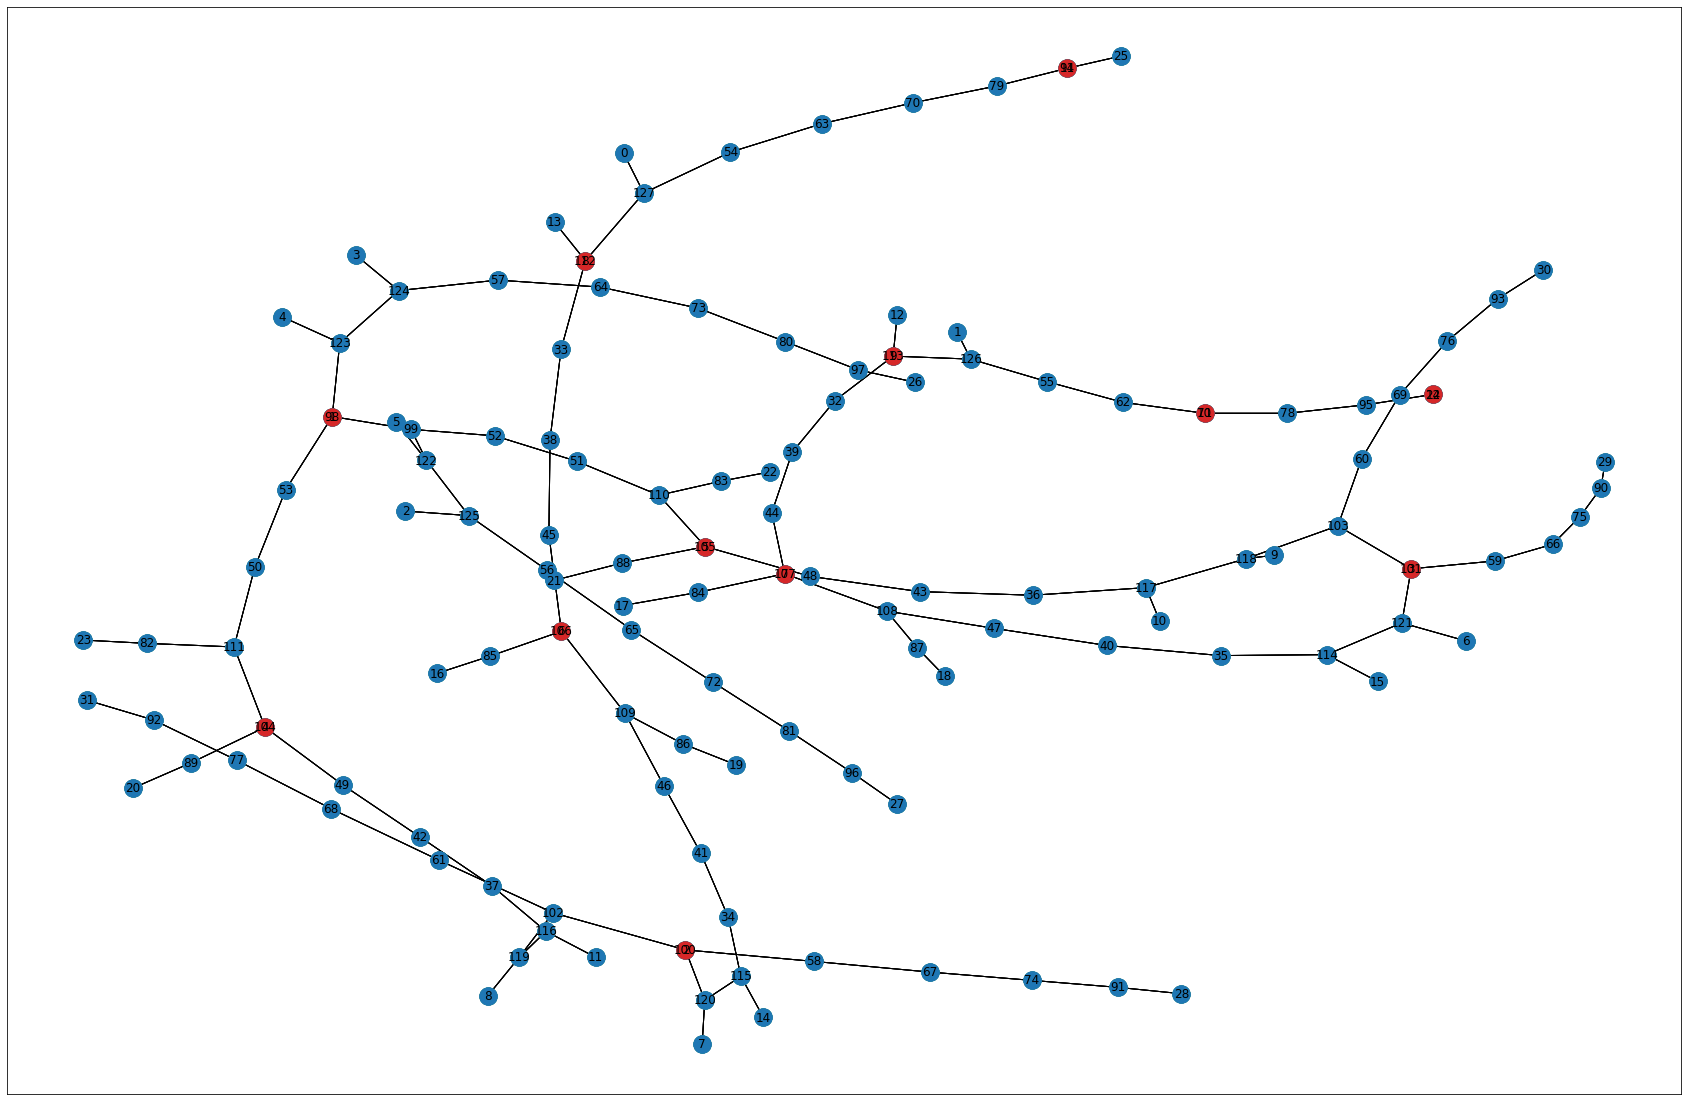

In [76]:
x = np.array(data[246])
n = x.shape[0]
k = math.ceil(pow(n,0.5))
l = k
g = nx.from_numpy_matrix(x)
drawgraph(g, k, l)

In [61]:
def check(data):
    num = 0
    for i in tqdm(range(len(data))):
        
        if len(data[i]) != 0:
            x = np.array(data[i])
            n = x.shape[0]
            k = math.ceil(pow(n,0.5))
            l = k
            g = nx.from_numpy_matrix(x)
            gs, gb, gt = isklburnable(g, k, l)
            if gt == False:
                num += 1
                yield show(g, gs, gb),num
        
        
    

In [62]:
result= check(data)

In [63]:
next(result)

 62%|██████▏   | 191/308 [00:00<00:00, 1781.79it/s]

True
True
False
False
Best sequence [] []
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
False
True
False
Best sequence [] []
Best sequence [4. 6. 8. 2.] [0, 1, 2.0, 3, 4.0, 5, 6.0, 7, 8.0, 9, 12]
True
False
True
True
False
True
False
Best sequence [] []
Best sequence [2. 5. 8. 0.] [0.0, 2.0, 3, 4, 5.0, 6, 7, 8.0, 9, 10]
Best sequence [2. 5. 9. 0.] [0.0, 2.0, 3, 4, 5.0, 6, 7, 8, 9.0, 10, 12]
True
True
True
True
True
True
True
False
True
False
True
True
False
True
True
True
True
False
False
True
True
True
False
Best sequence [] []
False
True
False
Best sequence [] []
Best sequence [ 6.  8. 10.  4.] [0, 1, 2, 3, 4.0, 5, 6.0, 7, 8.0, 9, 10.0, 11, 14]
False
True
True
True
False
Best sequence [] []
Best sequence [2. 5. 8. 0.] [0.0, 2.0, 3, 4, 5.0, 6, 7, 8.0, 9, 11]
False
True
True
True
True
False
True
True
False
True
False
True
True
False
False
Best sequence [] []
Best sequence [4. 6. 8. 2.] [0, 1, 2.0, 3, 4.0, 5, 6.0, 7, 8.0,

 80%|████████  | 247/308 [00:00<00:00, 966.26it/s] 

 [ 98. 100. 101. 104. 105. 106. 107. 112. 113.  55.  94.  24.] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24.0, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55.0, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94.0, 96, 97, 98.0, 99, 100.0, 101.0, 102, 103, 104.0, 105.0, 106.0, 107.0, 108, 109, 110, 111, 112.0, 113.0, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]
True
True
True
True
True
True
True
True
True
False
False
True
False
False
False
False
False
True
False
True
True
True
False
False
False
True
True
True
True
True
False
False
True
True
False
False
True
False
False
Best sequence [] []
True
False
True
True
True
False
False
True
False
False
False
True
True
True
True
True
True
False
Best sequence [] []
Best sequence [72. 73. 74. 75. 24. 78. 80

 80%|████████  | 247/308 [00:12<00:00, 966.26it/s]

Best sequence [72. 73. 74. 75. 24. 78. 32. 38. 88.  3.] [0, 1, 2, 3.0, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24.0, 25, 26, 27, 28, 29, 30, 31, 32.0, 33, 34, 35, 36, 37, 38.0, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72.0, 73.0, 74.0, 75.0, 76, 77, 78.0, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88.0, 89]


100%|██████████| 308/308 [00:25<00:00, 11.86it/s] 

True
True
True
True


StopIteration: 